In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            precision_recall_curve, roc_auc_score, RocCurveDisplay)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from google.colab import files

In [41]:
upload = files.upload()
loan_df = pd.read_csv('loan_approval_dataset.csv')
print("Original data shape:", loan_df.shape)

Saving loan_approval_dataset.csv to loan_approval_dataset (5).csv
Original data shape: (4269, 13)


In [47]:
loan_df.columns = loan_df.columns.str.strip()
print("Columns after stripping whitespace:", loan_df.columns.tolist())

if 'loan_id' in loan_df.columns:
    loan_df = loan_df.drop('loan_id', axis=1)
    print("loan_id column dropped.")

print("\nMissing values before handling:")
print(loan_df.isnull().sum())
target_column = None
for col in ['Loan_Status', 'Loan_status', 'Status', 'loan_status', 'Target', ' loan_status']:
    if col in loan_df.columns:
        target_column = col
        break

if not target_column:
    raise ValueError("Could not find target column in dataset")

categorical_features = []
numerical_features = []

for col in loan_df.columns:
    if col == target_column:
        continue
    if loan_df[col].dtype == 'object' or loan_df[col].nunique() < 10:
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print("\nIdentified Features:")
print("Categorical:", categorical_features)
print("Numerical:", numerical_features)
print("Target:", target_column)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', SimpleImputer(strategy='most_frequent'), categorical_features)
    ])

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

Columns after stripping whitespace: ['no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']

Missing values before handling:
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

Identified Features:
Categorical: ['no_of_dependents', 'education', 'self_employed']
Numerical: ['income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
Target: loan_status



Unique values in target column: [' Approved' ' Rejected']


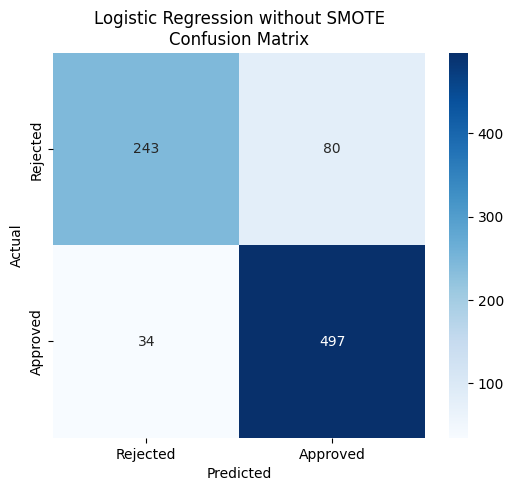


Unique values in target column: [' Approved' ' Rejected']
Error with Logistic Regression with SMOTE: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=42)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't

Unique values in target column: [' Approved' ' Rejected']


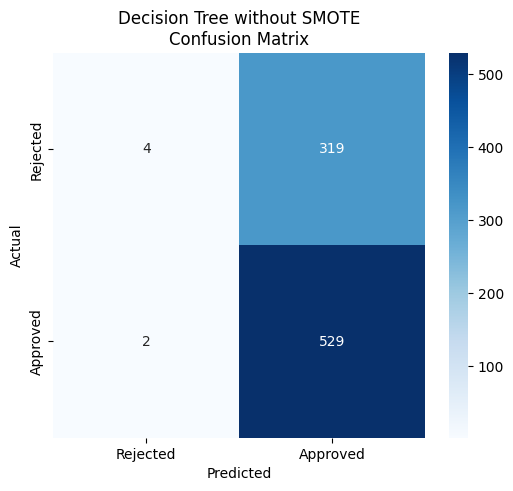


Unique values in target column: [' Approved' ' Rejected']
Error with Decision Tree with SMOTE: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=42)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't

Unique values in target column: [' Approved' ' Rejected']


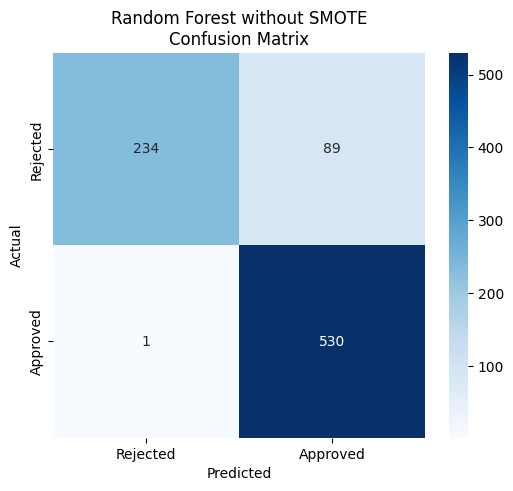


Unique values in target column: [' Approved' ' Rejected']
Error with Random Forest with SMOTE: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE(random_state=42)' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't


In [48]:
results = []
for model_name, model in models.items():
    for use_smote in [False, True]:
        # Create pipeline
        if use_smote:
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('encoder', OneHotEncoder(handle_unknown='ignore')),
                ('smote', SMOTE(random_state=42)),
                ('classifier', model)
            ])
            smote_label = "with SMOTE"
        else:
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('encoder', OneHotEncoder(handle_unknown='ignore')),
                ('classifier', model)
            ])
            smote_label = "without SMOTE"

        # Split data
        X = loan_df.drop(target_column, axis=1)

        # Convert target to binary
        print(f"\nUnique values in target column: {loan_df[target_column].unique()}")
        y = loan_df[target_column].copy()

        # Auto-detect target mapping
        positive_values = ['Y', 'Yes', 'Approved', '1', 1, 'yes', 'y', ' Approved'] # Added ' Approved'
        negative_values = ['N', 'No', 'Rejected', '0', 0, 'no', 'n', ' Rejected'] # Added ' Rejected'

        y = y.apply(lambda x: 1 if str(x).strip() in positive_values else 0)

        # Check if we have both classes
        class_counts = y.value_counts()
        if len(class_counts) < 2:
            print(f"Warning: Only one class found in target: {class_counts}")
            # Skip this iteration if we don't have both classes
            continue

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        try:
            # Train and evaluate
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

            # Handle models without predict_proba
            if hasattr(model, "predict_proba"):
                y_proba = pipeline.predict_proba(X_test)[:, 1]
                roc_auc = roc_auc_score(y_test, y_proba)
            else:
                y_proba = None
                roc_auc = np.nan

            # Store results
            report = classification_report(y_test, y_pred, output_dict=True)
            results.append({
                'Model': model_name,
                'SMOTE': smote_label,
                'Accuracy': report['accuracy'],
                'Precision': report['1']['precision'],
                'Recall': report['1']['recall'],
                'F1-Score': report['1']['f1-score'],
                'ROC-AUC': roc_auc
            })

            # Plot confusion matrix
            plt.figure(figsize=(6, 5))
            sns.heatmap(confusion_matrix(y_test, y_pred),
                        annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Rejected', 'Approved'],
                        yticklabels=['Rejected', 'Approved'])
            plt.title(f'{model_name} {smote_label}\nConfusion Matrix')
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()

        except Exception as e:
            print(f"Error with {model_name} {smote_label}: {str(e)}")
            continue


Model Comparison:
                 Model          SMOTE  Accuracy  Precision    Recall  \
0  Logistic Regression  without SMOTE  0.866511   0.861352  0.935970   
1        Decision Tree  without SMOTE  0.624122   0.623821  0.996234   
2        Random Forest  without SMOTE  0.894614   0.856220  0.998117   

   F1-Score   ROC-AUC  
0  0.897112  0.934751  
1  0.767223  0.585305  
2  0.921739  0.957694  


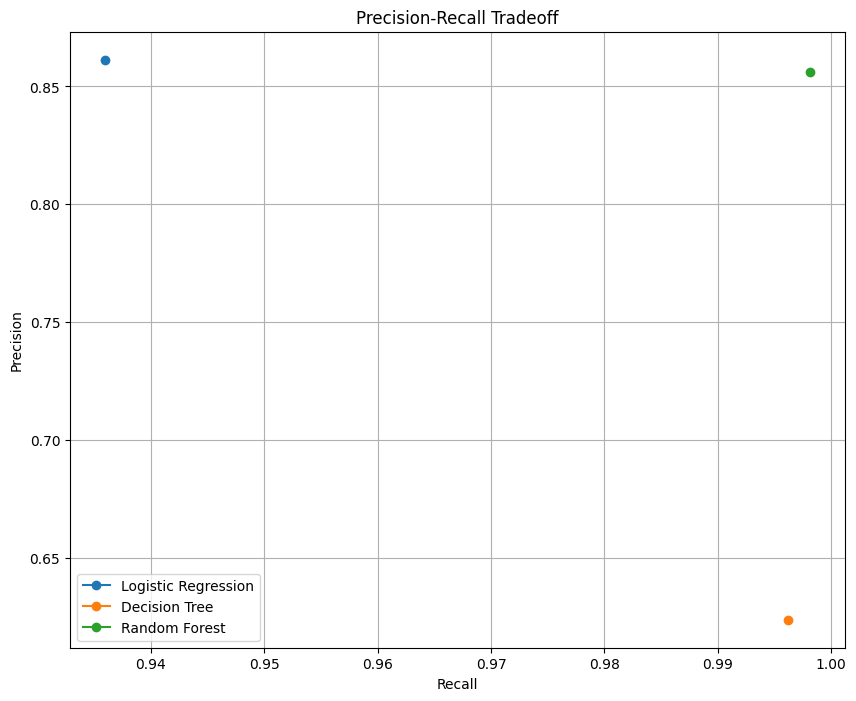

In [49]:
if results:
    results_df = pd.DataFrame(results)
    print("\nModel Comparison:")
    print(results_df)
    plt.figure(figsize=(10, 8))
    for model_name in models.keys():
        model_data = results_df[results_df['Model'] == model_name]
        if not model_data.empty:
            plt.plot(model_data['Recall'], model_data['Precision'], 'o-', label=model_name)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Tradeoff')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\nNo successful model runs. Check data and target variable.")